In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import subprocess
import sys
import io
import gradio as gr
import numpy as np
import random
import spaces
import torch
from diffusers import Flux2Pipeline, Flux2Transformer2DModel
from diffusers import BitsAndBytesConfig as DiffBitsAndBytesConfig
import requests
from PIL import Image
import json
import base64
from dotenv import load_dotenv
from huggingface_hub import login, InferenceClient
from helper_dev_utils import get_auto_logger
logger = get_auto_logger()

In [3]:
# Hugging Face 로그인 (FLUX 모델 접근 권한 필요)
load_dotenv()

# 환경 변수에서 토큰 가져오기 또는 직접 입력
hf_token = os.getenv("HF_TOKEN")
logger.info(f"Hugging Face Token: {hf_token[:2]} ... {hf_token[-2:]}")

if hf_token:
    login(token=hf_token)
    logger.debug("✓ Logged in with HF_TOKEN from environment")
else:
    # 수동 로그인 (토큰 입력 필요)
    login()
    logger.debug("✓ Manual login completed")

2026-01-26 22:08:27 I [ipykernel_launcher:6] - Hugging Face Token: hf ... LA


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


2026-01-26 22:08:27 D [ipykernel_launcher:10] - ✓ Logged in with HF_TOKEN from environment


In [4]:
"""
공간 분석 모듈: Qwen2-VL을 사용한 최적의 객체 배치 위치 탐지
Spatial Analysis Module: Detect optimal object placement using Qwen2-VL
"""

import sys
from pathlib import Path

# 프로젝트 경로 설정 (기존 유지)
project_root = Path.cwd().parent.parent / "src" / "nanoCocoa_aiserver"
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import logging
import re
from typing import Dict, List, Optional, Tuple, Union

import torch
from helper_dev_utils import get_auto_logger
from PIL import Image, ImageDraw
from qwen_vl_utils import process_vision_info
#from transformers import AutoProcessor, Qwen2VLForConditionalGeneration
from transformers import Qwen3VLForConditionalGeneration, AutoProcessor
#from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info

logger = get_auto_logger()

from utils import flush_gpu
from services.monitor import log_gpu_memory
from config import DEVICE, MODEL_IDS, TORCH_DTYPE

class QwenAnalyzer:
    """
    Qwen2-VL을 사용하여 배경 이미지에서 최적의 객체 배치 위치를 찾는 클래스

    이 클래스는 Vision-Language 모델을 사용하여 표면을 감지하고,
    바운딩 박스를 결정하며, 객체 합성을 위한 마스크를 생성합니다.

    Attributes:
        model_name (str): 사용할 HuggingFace 모델 이름
        device (str): 모델을 실행할 디바이스
        model: Qwen2-VL 모델 인스턴스
        processor: 이미지/텍스트 전처리 프로세서
        Qwen/Qwen2.5-VL-3B-Instruct
        Qwen/Qwen3-VL-4B-Instruct
        Qwen/Qwen3-VL-2B-Instruct
    """

    #def __init__(self, model_name: str = "Qwen/Qwen2.5-VL-3B-Instruct", device: str = DEVICE):
    #def __init__(self, model_name: str = "Qwen/Qwen3-VL-4B-Instruct", device: str = DEVICE):
    def __init__(self, model_name: str = "Qwen/Qwen3-VL-2B-Instruct", device: str = DEVICE):
        """
        QwenAnalyzer 초기화

        Args:
            model_name: HuggingFace 모델 식별자 (기본값: Qwen2-VL-7B-Instruct)
            device: 모델 실행 디바이스 ('cuda' 또는 'cpu', 기본값: 자동 감지)
        """
        self.model_name = model_name
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.model = None
        self.processor = None

        logger.debug(f"QwenAnalyzer 초기화: {model_name}")

    def unload(self) -> None:
        """명시적 리소스 정리 (표준 인터페이스)"""
        log_gpu_memory("QwenAnalyzer unload (before)")
        self._unload_model()
        log_gpu_memory("QwenAnalyzer unload (after)")

        logger.info("QwenAnalyzer unloaded")

    def _load_model(self):
        """Qwen2-VL 모델과 프로세서를 로드합니다."""
        if self.model is None:
            logger.debug(f"  Qwen 모델을 {self.device}에 로드 중...1")

            # # Vision-Language 모델 로드
            # self.model = Qwen2VLForConditionalGeneration.from_pretrained(
            #     self.model_name,
            #     torch_dtype=torch.bfloat16,  # 메모리 절약
            #     device_map="auto",  # 자동 디바이스 배치
            # )
            # self.model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
            #     self.model_name, dtype="auto", device_map="auto"
            # )
            self.model = Qwen3VLForConditionalGeneration.from_pretrained(
                self.model_name, dtype="auto", device_map="auto"
            )

            # 이미지와 텍스트 전처리를 위한 프로세서 로드
            self.processor = AutoProcessor.from_pretrained(self.model_name)

            logger.debug(f"  ✓ Qwen 모델 로드 완료")

    def _unload_model(self):
        """VRAM 확보를 위해 모델을 언로드합니다."""
        if self.model is not None:
            logger.debug("  Qwen2-VL 모델 언로드 중...")
            # device_map="auto"로 로드된 모델은 .to() 사용 불가
            # 직접 삭제 후 GPU 캐시 정리
            del self.model
            del self.processor
            self.model = None
            self.processor = None
            flush_gpu()  # GPU 캐시 정리

    def detect_surface(
        self,
        image: Union[Image.Image, str],
        query: str = "Find the flat surface where I can place an object. Return the bounding box coordinates.",
        auto_unload: bool = True,
    ) -> Dict[str, any]:
        """
        객체 배치를 위한 최적의 표면을 탐지합니다.

        Vision-Language 모델에 이미지와 질문을 제공하여
        객체를 놓을 수 있는 최적의 위치를 찾습니다.

        Args:
            image: PIL Image 객체 또는 이미지 경로
            query: VL 모델에 물어볼 질문 (위치 탐지 요청)
            auto_unload: 추론 후 자동으로 모델 언로드 여부 (기본값: True)

        Returns:
            다음을 포함하는 딕셔너리:
                - 'bbox': [x1, y1, x2, y2] 정규화된 좌표 (0-1000 범위)
                - 'text': 모델의 전체 응답 텍스트
                - 'image_size': 입력 이미지의 (width, height)

        Example:
            >>> analyzer = QwenAnalyzer()
            >>> result = analyzer.detect_surface(
            ...     bg_image,
            ...     "맥주병을 놓을 테이블 중앙을 찾아주세요"
            ... )
            >>> bbox = result['bbox']  # [x1, y1, x2, y2]
        """
        try:
            # 모델 로드 (필요시)
            self._load_model()

            # 경로가 제공된 경우 이미지 로드
            if isinstance(image, str):
                image = Image.open(image)

            image_size = image.size  # (width, height)

            logger.debug(f"  이미지 분석 중 ({image_size[0]}x{image_size[1]})...")
            logger.debug(f"  질문: {query}")

            # 모델을 위한 메시지 준비 (멀티모달 입력)
            messages = [
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "image",
                            "image": image,  # 이미지 입력
                        },
                        {"type": "text", "text": query},  # 텍스트 질문
                    ],
                }
            ]

            # 입력 전처리
            text = self.processor.apply_chat_template(
                messages, tokenize=False, add_generation_prompt=True
            )
            image_inputs, video_inputs = process_vision_info(messages)

            inputs = self.processor(
                text=[text],
                images=image_inputs,
                videos=video_inputs,
                padding=True,
                return_tensors="pt",
            )
            inputs = inputs.to(self.device)

            # 응답 생성 (추론)
            with torch.no_grad():  # 그래디언트 계산 비활성화
                generated_ids = self.model.generate(
                    **inputs, max_new_tokens=256  # 최대 응답 길이
                )

            # 입력 토큰 제거 (생성된 부분만 추출)
            generated_ids_trimmed = [
                out_ids[len(in_ids) :]
                for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
            ]

            # 응답 디코딩 (토큰 -> 텍스트)
            output_text = self.processor.batch_decode(
                generated_ids_trimmed,
                skip_special_tokens=True,
                clean_up_tokenization_spaces=False,
            )[0]

            logger.debug(f"  모델 응답: {output_text[:100]}...")

            # 응답에서 바운딩 박스 파싱
            bbox = self._parse_bbox(output_text)

            result = {"bbox": bbox, "text": output_text, "image_size": image_size}

            logger.debug(f"  ✓ 표면 탐지 완료: {bbox}")

            return result

        finally:
            # VRAM 확보를 위해 모델 언로드
            if auto_unload:
                self._unload_model()

    def analyze_image_details(
        self,
        image: Image.Image,
        custom_query: Optional[str] = None,
        auto_unload: bool = True,
    ) -> Dict[str, Union[str, Tuple[int, int]]]:
        """
        이미지를 상세 분석하여 텍스트 정보를 반환합니다.

        Args:
            image: PIL Image 객체
            custom_query: 사용자 정의 분석 질문 (선택)
            auto_unload: 분석 후 자동으로 모델 언로드 여부 (기본값: True)

        Returns:
            다음을 포함하는 딕셔너리:
                - 'spatial': 객체의 공간적 배치 및 위치 정보
                - 'color_material': 색감 및 재질 분석
                - 'overall': 전체적인 장면 설명
                - 'lighting_mood': 조명, 분위기, 시간대 분석
                - 'custom': 사용자 정의 질문 응답 (custom_query 제공 시)

        Example:
            >>> analyzer = QwenAnalyzer()
            >>> bg_image = Image.open("background.jpg")
            >>> result = analyzer.analyze_image_details(bg_image)
            >>> print(result['spatial'])
            >>> print(result['overall'])
        """
        try:
            self._load_model()

            image_size = image.size
            logger.info(f"이미지 상세 분석 시작 ({image_size[0]}x{image_size[1]})")

            # 1. 공간적 배치 분석
            spatial_query = (
                "Describe the spatial layout of objects in this image. "
                "Where is each object located? What are their positions relative to each other? "
                "Answer in English."
            )
            spatial_info = self._query_model(image, spatial_query)
            logger.debug(f"공간 분석 완료: {spatial_info[:100]}...")

            # 2. 색감 및 재질 분석
            color_material_query = (
                "Analyze the colors and materials in this image. "
                "What colors dominate the scene? What materials can you identify "
                "(metal, wood, fabric, glass, etc.)? Answer in English."
            )
            color_material_info = self._query_model(image, color_material_query)
            logger.debug(f"색감/재질 분석 완료: {color_material_info[:100]}...")

            # 3. 전체적인 내용 분석
            overall_query = (
                "Provide a comprehensive description of this image. "
                "What is the main subject? What is happening in the scene? "
                "What is the context or setting? Answer in English."
            )
            overall_info = self._query_model(image, overall_query)
            logger.debug(f"전체 내용 분석 완료: {overall_info[:100]}...")

            # 4. 조명 및 분위기 분석
            lighting_mood_query = (
                "Describe the lighting, atmosphere, and mood of this image. "
                "What time of day does it appear to be? What is the emotional tone? "
                "Are there any notable lighting effects? Answer in English."
            )
            lighting_mood_info = self._query_model(image, lighting_mood_query)
            logger.debug(f"조명/분위기 분석 완료: {lighting_mood_info[:100]}...")

            result = {
                "spatial": spatial_info,
                "color_material": color_material_info,
                "overall": overall_info,
                "lighting_mood": lighting_mood_info,
                "image_size": image_size,
            }

            # 사용자 정의 질문 처리
            if custom_query:
                logger.debug(f"사용자 정의 질문: {custom_query}")
                custom_info = self._query_model(image, custom_query)
                result["custom"] = custom_info
                logger.debug(f"사용자 정의 응답: {custom_info[:100]}...")

            logger.info("이미지 상세 분석 완료")
            return result

        finally:
            if auto_unload:
                self._unload_model()

    def analyze_image(
        self,
        image: Image.Image,
        query: Optional[str],
        auto_unload: bool = True,
    ) -> str:
        """
        이미지를 상세 분석하여 텍스트 정보를 반환합니다.

        Args:
            image: PIL Image 객체
            query: 사용자 정의 분석 질문 (선택)
            auto_unload: 분석 후 자동으로 모델 언로드 여부 (기본값: True)

        Returns:
            다음을 포함하는 딕셔너리:
                - 'spatial': 객체의 공간적 배치 및 위치 정보
                - 'color_material': 색감 및 재질 분석
                - 'overall': 전체적인 장면 설명
                - 'lighting_mood': 조명, 분위기, 시간대 분석
                - 'custom': 사용자 정의 질문 응답 (custom_query 제공 시)

        Example:
            >>> analyzer = QwenAnalyzer()
            >>> bg_image = Image.open("background.jpg")
            >>> result = analyzer.analyze_image_details(bg_image)
            >>> print(result['spatial'])
            >>> print(result['overall'])
        """
        try:
            self._load_model()

            image_size = image.size
            logger.info(f"이미지 상세 분석 시작 ({image_size[0]}x{image_size[1]})")

            # 사용자 정의 질문 처리
            logger.debug(f"사용자 정의 질문: {query}")
            custom_info = self._query_model(image, query)
            result = custom_info
            logger.debug(f"사용자 정의 응답: {custom_info[:100]}...")

            logger.info("이미지 상세 분석 완료")
            return result

        finally:
            if auto_unload:
                self._unload_model()

    def analyze_image_flux_product(
        self,
        image: Image.Image,
        auto_unload: bool = True,
    ) -> str:
        """
        이미지를 상세 분석하여 텍스트 정보를 반환합니다.

        Args:
            image: PIL Image 객체
            auto_unload: 분석 후 자동으로 모델 언로드 여부 (기본값: True)

        Returns:
            제품 분석 텍스트:
            [Product Description from Qwen] placed on [New Background], [Interaction Detail], [Lighting Match], [Technical Quality]

        Example:
            >>> analyzer = QwenAnalyzer()
            >>> bg_image = Image.open("background.jpg")
            >>> result = analyzer.analyze_image_flux_product(bg_image)
            >>> print(result)
        """
        try:
            self._load_model()

            image_size = image.size
            logger.info(f"이미지 상세 분석 시작 ({image_size[0]}x{image_size[1]})")

            # 사용자 정의 질문 처리
            query = "[Product Description from Qwen] placed on [New Background], [Interaction Detail], [Lighting Match], [Technical Quality]"
            logger.debug(f"사용자 정의 질문: {query}")
            custom_info = self._query_model(image, query)
            result = custom_info
            logger.debug(f"사용자 정의 응답: {custom_info[:100]}...")

            logger.info("이미지 상세 분석 완료")
            return result

        finally:
            if auto_unload:
                self._unload_model()

    def _query_model(self, image: Image.Image, query: str) -> str:
        """
        이미지에 대한 단일 질문을 모델에 전달하고 응답을 반환합니다.

        Args:
            image: PIL Image 객체
            query: 질문 텍스트

        Returns:
            모델의 응답 텍스트
        """
        # 모델을 위한 메시지 준비
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": image},
                    {"type": "text", "text": query},
                ],
            }
        ]

        # 입력 전처리
        text = self.processor.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )
        image_inputs, video_inputs = process_vision_info(messages)

        inputs = self.processor(
            text=[text],
            images=image_inputs,
            videos=video_inputs,
            padding=True,
            return_tensors="pt",
        )
        inputs = inputs.to(self.device)

        # 응답 생성
        with torch.no_grad():
            generated_ids = self.model.generate(
                **inputs, max_new_tokens=512  # 더 긴 응답 허용
            )

        # 입력 토큰 제거
        generated_ids_trimmed = [
            out_ids[len(in_ids) :]
            for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
        ]

        # 응답 디코딩
        output_text = self.processor.batch_decode(
            generated_ids_trimmed,
            skip_special_tokens=True,
            clean_up_tokenization_spaces=False,
        )[0]

        return output_text.strip()

    def _parse_bbox(self, text: str) -> List[int]:
        """
        모델 출력에서 바운딩 박스 좌표를 파싱합니다.

        Qwen-VL은 일반적으로 다음 형식으로 bbox를 반환합니다:
        - 형식 1: <|box_start|>(x1,y1),(x2,y2)<|box_end|>
        - 형식 2: 텍스트 내의 숫자 나열

        Returns:
            정규화된 좌표의 [x1, y1, x2, y2] (0-1000 범위)
        """
        # 패턴 1: <|box_start|>(x1,y1),(x2,y2)<|box_end|> 형태 찾기
        box_pattern = r"<\|box_start\|\>\((\d+),(\d+)\),\((\d+),(\d+)\)<\|box_end\|\>"
        match = re.search(box_pattern, text)

        if match:
            return [
                int(match.group(1)),
                int(match.group(2)),
                int(match.group(3)),
                int(match.group(4)),
            ]

        # 패턴 2: 콤마로 구분된 4개의 숫자 찾기
        numbers = re.findall(r"\b\d+\b", text)
        if len(numbers) >= 4:
            # 처음 4개 숫자를 bbox로 사용
            return [int(numbers[0]), int(numbers[1]), int(numbers[2]), int(numbers[3])]

        # 기본값: 파싱 실패 시 중앙 영역 사용
        logger.debug("  ⚠ bbox 파싱 실패, 중앙 영역 사용")
        return [400, 400, 600, 600]  # 중앙 영역 (정규화 0-1000)

    def create_mask(
        self,
        image_size: Tuple[int, int],
        bbox: List[int],
        mask_color: int = 255,
        background_color: int = 0,
    ) -> Image.Image:
        """
        바운딩 박스 좌표로부터 이진 마스크를 생성합니다.

        Args:
            image_size: 대상 이미지의 (width, height)
            bbox: 정규화된 좌표의 [x1, y1, x2, y2] (0-1000 범위)
            mask_color: 마스크 영역의 색상 (기본값: 255 = 흰색)
            background_color: 배경 색상 (기본값: 0 = 검정)

        Returns:
            이진 마스크 이미지 ('L' 모드의 PIL.Image)

        Example:
            >>> mask = analyzer.create_mask((1024, 1024), [400, 400, 600, 600])
        """
        width, height = image_size

        # 정규화된 좌표(0-1000)를 픽셀 좌표로 변환
        x1 = int(bbox[0] * width / 1000)
        y1 = int(bbox[1] * height / 1000)
        x2 = int(bbox[2] * width / 1000)
        y2 = int(bbox[3] * height / 1000)

        # 검은 배경 생성
        mask = Image.new("L", image_size, background_color)
        draw = ImageDraw.Draw(mask)

        # 마스크 영역에 흰색 사각형 그리기
        draw.rectangle([x1, y1, x2, y2], fill=mask_color)

        logger.debug(
            f"  ✓ 마스크 생성 완료: {image_size[0]}x{image_size[1]}, "
            f"영역: ({x1},{y1})-({x2},{y2})"
        )

        return mask

    def visualize_bbox(
        self, image: Image.Image, bbox: List[int], color: str = "red", width: int = 3
    ) -> Image.Image:
        """
        이미지에 바운딩 박스를 시각화합니다.

        Args:
            image: 입력 PIL Image
            bbox: 정규화된 좌표의 [x1, y1, x2, y2] (0-1000 범위)
            color: 바운딩 박스 색상
            width: 선 두께

        Returns:
            바운딩 박스가 그려진 이미지

        Example:
            >>> bbox_img = analyzer.visualize_bbox(bg_image, [400, 400, 600, 600])
        """
        img_copy = image.copy()
        draw = ImageDraw.Draw(img_copy)

        # 정규화된 좌표를 픽셀 좌표로 변환
        img_width, img_height = image.size
        x1 = int(bbox[0] * img_width / 1000)
        y1 = int(bbox[1] * img_height / 1000)
        x2 = int(bbox[2] * img_width / 1000)
        y2 = int(bbox[3] * img_height / 1000)

        # 사각형 그리기
        draw.rectangle([x1, y1, x2, y2], outline=color, width=width)

        return img_copy

    def __del__(self):
        """객체 소멸 시 정리 작업"""
        self._unload_model()



In [5]:
qwen = QwenAnalyzer()

2026-01-26 22:08:28 D [ipykernel_launcher:65] - QwenAnalyzer 초기화: Qwen/Qwen3-VL-2B-Instruct


In [6]:
# OpenAI API 키 확인
openai_api_key = os.getenv("OPENAI_API_KEY")

if not openai_api_key:
    logger.error("OPENAI_API_KEY 환경 변수가 설정되지 않았습니다.")
    logger.error("   .env 파일에 다음을 추가하세요:")
    logger.error("   OPENAI_API_KEY=sk-...")
    raise ValueError("OPENAI_API_KEY가 설정되지 않았습니다")
else:
    logger.debug(f"OpenAI API 키 확인됨 (길이: {len(openai_api_key)} 문자)")
    logger.debug(f"   키 prefix: {openai_api_key[:5]} --- {openai_api_key[-5:]}")

2026-01-26 22:08:28 D [ipykernel_launcher:10] - OpenAI API 키 확인됨 (길이: 164 문자)
2026-01-26 22:08:28 D [ipykernel_launcher:11] -    키 prefix: sk-pr --- cxzEA


In [ ]:
import sys
from pathlib import Path

import io
import re
import shutil
import tempfile
from pathlib import Path
from typing import Dict, Optional, Union

from helper_dev_utils import get_auto_logger
from openai import OpenAI
from PIL import Image
from playwright.async_api import async_playwright

logger = get_auto_logger()

class LLMPrompt:
    """
    QwenAnalyzer와 OpenAI LLM을 사용한 HTML 광고 생성기

    이미지와 광고 문구를 입력받아 LLM이 HTML 광고 템플릿을 생성하고,
    Playwright로 실제 이미지로 렌더링합니다.

    특징:
    - QwenAnalyzer로 이미지 상세 분석 (공간, 색감, 조명, 분위기)
    - 텍스트 기반 프롬프트로 토큰 효율 최적화
    - gpt-5-mini 모델 지원 (128K 출력 토큰)
    - 비동기 Playwright로 HTML 렌더링
    - 완전한 HTML 생성 보장 (finish_reason 검증)
    """

    def __init__(
        self,
        api_key: str,
        model: str = "gpt-5-mini",
        temperature: float = 1.0,
        max_completion_tokens: int = 128000,
        qwen: Optional[QwenAnalyzer] = None,
    ):
        """
        LLMTexttoHTML 초기화

        Args:
            api_key: OpenAI API 키
            model: 사용할 모델 (기본값: gpt-5-mini, 128K 출력 지원)
            temperature: 생성 다양성 (0.0-2.0, 기본값: 0.7)
            max_completion_tokens: 최대 출력 토큰 (기본값: 128000)
        """
        self.openai_client = OpenAI(api_key=api_key)
        self.model = model
        self.temperature = temperature
        self.max_completion_tokens = max_completion_tokens
        self.mode_qwen = qwen or QwenAnalyzer()

        logger.info(
            f"LLMTexttoHTML 초기화: model={model}, max_tokens={max_completion_tokens}"
        )

    def generate_html(
        self,
        image_path: str,
        ad_text: str,
        style_hint: Optional[str] = None,
    ) -> str:
        """
        이미지와 광고 문구를 분석하여 HTML 광고 템플릿 생성

        Args:
            image_path: 분석할 이미지 경로
            ad_text: 광고 문구 (예: "특가세일 2500원")
            style_hint: 스타일 힌트 (예: "modern", "elegant", "energetic")

        Returns:
            생성된 HTML 문자열
        """
        logger.info(f"HTML 생성 시작: image={image_path}, text={ad_text}")

        # QwenAnalyzer로 이미지 상세 분석
        logger.info("QwenAnalyzer로 이미지 분석 중...")
        qwen = self.mode_qwen
        image = Image.open(image_path)
        analysis = qwen.analyze_image_details(image, auto_unload=False)

        # 프롬프트 구성
        system_prompt = f"""당신은 전문 HTML 광고 디자이너입니다.
이미지를 분석하여 이미지와 어울리는 완전한 광고 HTML을 생성합니다.

[핵심 요구사항]
- 반드시 완전한 HTML 문서를 생성 (<!DOCTYPE html>부터 </html>까지)
- 인라인 CSS 스타일 포함
- 반응형 디자인 (width: 1024px, height:1024px)
- 이미지 분석 정보를 참고 하여 광고에 어울리는 디자인 구성
- {image_path} 배경 이미지로 사용
- 이미지는 비율유지 full cover
- 텍스트 오버레이로 광고 문구 배치
- 깔끔한 타이포그래피와 적절한 여백
- 그라디언트나 그림자로 가독성 향상
- JavaScript 사용하지 않음

[중요]
- HTML을 끝까지 완성해야 합니다
- </html> 태그로 반드시 종료
- 중간에 생략하지 말 것"""

        user_prompt = f"""다음 이미지 분석 정보를 바탕으로 광고 문구가 포함된 완전한 HTML을 생성해주세요:

[이미지 분석 정보]
- 전체 장면: {analysis['overall']}
- 색감/재질: {analysis['color_material']}
- 조명/분위기: {analysis['lighting_mood']}
- 공간 배치: {analysis['spatial']}
- 이미지 크기: {analysis['image_size'][0]}x{analysis['image_size'][1]}px

[광고 정보]
- 광고 문구: "{ad_text}"
{f'- 스타일 힌트: {style_hint}' if style_hint else ''}

[요구사항]
- 위 이미지 분석 정보를 참고하여 조화로운 디자인 구성
- 광고 문구 레이어 투명
- 광고 문구를 눈에 띄게 배치
- 텍스트 크기와 색상은 배경과 대비되도록 설정
- {image_path} 백그라운드로 사용
- 백그라운드 크기 고정 width: 1024px, height:1024px

[출력 형식]
- 완성된 HTML 코드만 출력 (설명 없이)
- 반드시 <!DOCTYPE html>부터 </html>까지 전체 코드 출력
- 코드 블록 마크다운(```) 사용하지 말고 순수 HTML만 출력"""

        messages = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]

        # OpenAI API 호출
        logger.debug(
            f"OpenAI API 호출 시작: model={self.model}, max_tokens={self.max_completion_tokens}"
        )
        response = self.openai_client.chat.completions.create(
            model=self.model,
            messages=messages,
            temperature=self.temperature,
            max_completion_tokens=self.max_completion_tokens,
        )

        html_output = response.choices[0].message.content
        finish_reason = response.choices[0].finish_reason

        logger.debug(
            f"API 응답 완료: finish_reason={finish_reason}, 토큰 사용={response.usage.total_tokens}"
        )

        if not html_output:
            logger.error("OpenAI API가 빈 응답을 반환했습니다")
            raise ValueError("HTML 생성 실패: 빈 응답")

        # finish_reason이 length인 경우 경고
        if finish_reason == "length":
            logger.warning("HTML이 max_completion_tokens 제한으로 잘렸을 수 있습니다")
            logger.warning(
                f"현재 max_completion_tokens={self.max_completion_tokens}, 사용된 토큰={response.usage.completion_tokens}"
            )

        logger.info(
            f"HTML 생성 완료: {len(html_output)} 문자, finish_reason={finish_reason}"
        )

        # HTML 코드 블록 제거 (```html ... ``` 형식인 경우)
        if "```" in html_output:
            parts = html_output.split("```")
            for i, part in enumerate(parts):
                if part.strip().startswith("html"):
                    html_output = part[4:].strip()
                    break
                elif i % 2 == 1:  # 홀수 인덱스는 코드 블록 내부
                    html_output = part.strip()
                    break

        # HTML 유효성 간단 체크
        html_lower = html_output.lower()
        if not html_lower.startswith("<!doctype html") and not html_lower.startswith(
            "<html"
        ):
            logger.warning("HTML이 올바른 형식으로 시작하지 않습니다")

        if "</html>" not in html_lower:
            logger.warning("HTML이 </html> 태그로 종료되지 않았습니다 (잘렸을 가능성)")

        return html_output

    def generate_prompt_html(
        self,
        image_path: str,
        ad_text: str,
        text_prompt: Optional[str] = None,
        composition_prompt: Optional[str] = None,
    ) -> str:
        """
        이미지와 광고 문구를 분석하여 HTML 광고 템플릿 생성

        Args:
            image_path: 분석할 이미지 경로
            ad_text: 광고 문구 (예: "특가세일 2500원")
            text_prompt: 텍스트 프롬프트 (선택)
            composition_prompt: 구성 프롬프트 (선택)

        Returns:
            생성된 HTML 문자열
        """
        logger.info(f"HTML 생성 시작: image={image_path}, text={ad_text}")

        # QwenAnalyzer로 이미지 상세 분석
        logger.info("QwenAnalyzer로 이미지 분석 중...")
        qwen = self.mode_qwen
        image = Image.open(image_path)
        analysis = qwen.analyze_image_details(image, auto_unload=False)

        # 프롬프트 구성
        system_prompt = f"""당신은 전문 HTML 광고 디자이너입니다.
이미지 분석 정보를 바탕으로 이미지와 어울리는 완전한 광고 HTML을 생성합니다.

[핵심 요구사항]
- 반드시 완전한 HTML 문서를 생성 (<!DOCTYPE html>부터 </html>까지)
- 인라인 CSS 스타일 포함
- 반응형 디자인 (width: 1024px, height:1024px)
- 이미지 분석 정보를 참고 하여 광고에 어울리는 디자인 구성
- {image_path} 배경 이미지로 사용
- 이미지는 비율유지 full cover
- 텍스트 오버레이로 광고 문구 배치
- 깔끔한 타이포그래피와 적절한 여백
- 그라디언트나 그림자로 가독성 향상
- JavaScript 사용하지 않음

[중요]
- HTML을 끝까지 완성해야 합니다
- </html> 태그로 반드시 종료
- 중간에 생략하지 말 것"""

        user_prompt = f"""다음 이미지 분석 정보를 바탕으로 광고 문구가 포함된 완전한 HTML을 생성해주세요:

[이미지 분석 정보]
- 전체 장면: {analysis['overall']}
- 색감/재질: {analysis['color_material']}
- 조명/분위기: {analysis['lighting_mood']}
- 공간 배치: {analysis['spatial']}
- 이미지 크기: {analysis['image_size'][0]}x{analysis['image_size'][1]}px

[광고 정보]
- 광고 문구: "{ad_text}"
{f'- 텍스트 프롬프트: {text_prompt}' if text_prompt else ''}
{f'- 구성 프롬프트: {composition_prompt}' if composition_prompt else ''}

[요구사항]
- 위 이미지 분석 정보를 참고하여 조화로운 디자인 구성
- 광고 문구 레이어 투명
- 광고 문구를 눈에 띄게 배치
- 텍스트 크기와 색상은 배경과 대비되도록 설정
- {image_path} 백그라운드로 사용
- 백그라운드 크기 고정 width: 1024px, height:1024px

[출력 형식]
- 완성된 HTML 코드만 출력 (설명 없이)
- 반드시 <!DOCTYPE html>부터 </html>까지 전체 코드 출력
- 코드 블록 마크다운(```) 사용하지 말고 순수 HTML만 출력"""

        messages = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]

        # OpenAI API 호출
        logger.debug(
            f"OpenAI API 호출 시작: model={self.model}, max_tokens={self.max_completion_tokens}"
        )
        response = self.openai_client.chat.completions.create(
            model=self.model,
            messages=messages,
            temperature=self.temperature,
            max_completion_tokens=self.max_completion_tokens,
        )

        html_output = response.choices[0].message.content
        finish_reason = response.choices[0].finish_reason

        logger.debug(
            f"API 응답 완료: finish_reason={finish_reason}, 토큰 사용={response.usage.total_tokens}"
        )

        if not html_output:
            logger.error("OpenAI API가 빈 응답을 반환했습니다")
            raise ValueError("HTML 생성 실패: 빈 응답")

        # finish_reason이 length인 경우 경고
        if finish_reason == "length":
            logger.warning("HTML이 max_completion_tokens 제한으로 잘렸을 수 있습니다")
            logger.warning(
                f"현재 max_completion_tokens={self.max_completion_tokens}, 사용된 토큰={response.usage.completion_tokens}"
            )

        logger.info(
            f"HTML 생성 완료: {len(html_output)} 문자, finish_reason={finish_reason}"
        )

        # HTML 코드 블록 제거 (```html ... ``` 형식인 경우)
        if "```" in html_output:
            parts = html_output.split("```")
            for i, part in enumerate(parts):
                if part.strip().startswith("html"):
                    html_output = part[4:].strip()
                    break
                elif i % 2 == 1:  # 홀수 인덱스는 코드 블록 내부
                    html_output = part.strip()
                    break

        # HTML 유효성 간단 체크
        html_lower = html_output.lower()
        if not html_lower.startswith("<!doctype html") and not html_lower.startswith(
            "<html"
        ):
            logger.warning("HTML이 올바른 형식으로 시작하지 않습니다")

        if "</html>" not in html_lower:
            logger.warning("HTML이 </html> 태그로 종료되지 않았습니다 (잘렸을 가능성)")

        return html_output

    async def render_html_to_image(
        self,
        html_path: str,
        output_path: str,
        width: int = 1024,
        height: int = 1024,
        timeout: int = 30000,
    ) -> str:
        """
        Playwright로 HTML 파일을 이미지로 렌더링 (비동기)

        Args:
            html_path: 렌더링할 HTML 파일 경로
            output_path: 출력 이미지 경로
            width: 뷰포트 너비
            height: 뷰포트 높이
            timeout: 배경 이미지 로딩 대기 타임아웃 (밀리초, 기본값: 30000)

        Returns:
            저장된 이미지 경로
        """
        logger.info(
            f"HTML → 이미지 렌더링 시작: html={html_path}, output={output_path}, timeout={timeout}ms"
        )

        # HTML 파일을 file:// URL로 변환
        html_file_url = Path(html_path).resolve().as_uri()
        logger.debug(f"HTML 파일 URL: {html_file_url}")

        async with async_playwright() as p:
            browser = await p.chromium.launch()
            page = await browser.new_page(viewport={"width": width, "height": height})

            # HTML 파일 로드 (file:// 프로토콜로 상대 경로 이미지 자동 해석)
            await page.goto(html_file_url, wait_until="domcontentloaded")

            # 배경 이미지 로딩 대기 (networkidle 또는 수동 체크)
            logger.info("배경 이미지 로딩 대기 중...")
            try:
                # 네트워크 유휴 상태까지 대기 (이미지 로드 포함)
                await page.wait_for_load_state("networkidle", timeout=timeout)
                logger.info("네트워크 유휴 상태 도달 (이미지 로드 완료)")
            except Exception as e:
                logger.warning(f"networkidle 타임아웃 ({timeout}ms): {e}")
                logger.info("수동 배경 이미지 로딩 체크 진행...")

            # 추가 검증: JavaScript로 배경 이미지 로딩 상태 확인
            try:
                bg_loaded = await page.evaluate(
                    """
                    async () => {
                        const checkBackgroundImage = () => {
                            const elements = document.querySelectorAll('*');
                            const bgElements = [];
                            
                            elements.forEach(el => {
                                const bgImage = window.getComputedStyle(el).backgroundImage;
                                if (bgImage && bgImage !== 'none' && bgImage.includes('url(')) {
                                    bgElements.push({
                                        element: el,
                                        bgImage: bgImage
                                    });
                                }
                            });
                            
                            return bgElements;
                        };
                        
                        // 배경 이미지 요소 찾기
                        const bgElements = checkBackgroundImage();
                        
                        if (bgElements.length === 0) {
                            return { loaded: false, count: 0, message: '배경 이미지 요소 없음' };
                        }
                        
                        // 각 배경 이미지 로딩 대기
                        const loadPromises = bgElements.map(({ element, bgImage }) => {
                            return new Promise((resolve) => {
                                // URL 추출
                                const urlMatch = bgImage.match(/url\\(['"]?([^'"()]+)['"]?\\)/);
                                if (!urlMatch) {
                                    resolve({ success: false, url: bgImage });
                                    return;
                                }
                                
                                const imageUrl = urlMatch[1];
                                
                                // Base64 이미지는 즉시 로드됨
                                if (imageUrl.startsWith('data:')) {
                                    resolve({ success: true, url: 'base64 image' });
                                    return;
                                }
                                
                                // 일반 URL 이미지 프리로드
                                const img = new Image();
                                img.onload = () => resolve({ success: true, url: imageUrl });
                                img.onerror = () => resolve({ success: false, url: imageUrl });
                                img.src = imageUrl;
                            });
                        });
                        
                        const results = await Promise.all(loadPromises);
                        const loadedCount = results.filter(r => r.success).length;
                        
                        return {
                            loaded: loadedCount > 0,
                            count: bgElements.length,
                            loadedCount: loadedCount,
                            results: results
                        };
                    }
                """
                )

                if bg_loaded["loaded"]:
                    logger.info(
                        f"배경 이미지 로딩 완료: {bg_loaded['loadedCount']}/{bg_loaded['count']}개"
                    )
                    for idx, result in enumerate(bg_loaded.get("results", [])[:3]):
                        status = "✓" if result["success"] else "✗"
                        url_display = (
                            result["url"][:60]
                            if len(result["url"]) > 60
                            else result["url"]
                        )
                        logger.debug(f"  {status} 이미지 {idx+1}: {url_display}...")
                else:
                    logger.warning(
                        f"배경 이미지 로딩 실패: {bg_loaded.get('message', '알 수 없는 오류')}"
                    )

            except Exception as e:
                logger.error(f"배경 이미지 로딩 확인 중 오류: {e}")

            # 추가 렌더링 대기
            await page.wait_for_timeout(1000)

            # 스크린샷
            await page.screenshot(path=output_path, full_page=True)

            await browser.close()

        logger.info(f"이미지 렌더링 완료: {output_path}")
        return output_path

    async def generate_prompt_html_png(
        self,
        image: Union[Image.Image, str],
        ad_text: str,
        text_prompt: Optional[str] = None,
        composition_prompt: Optional[str] = None,
    ) -> Image.Image:
        """
        이미지와 광고 문구를 분석하여 PNG 광고 이미지 생성

        Args:
            image: PIL Image 객체 또는 이미지 경로
            ad_text: 광고 문구
            text_prompt: 텍스트 프롬프트
            composition_prompt: 구성 프롬프트

        Returns:
            생성된 PIL Image 객체
        """
        temp_image_path = None
        temp_html_path = None
        temp_output_path = None

        try:
            # 임시 디렉토리 생성
            temp_dir = Path(tempfile.mkdtemp(prefix="llm_html_"))
            logger.debug(f"임시 디렉토리 생성: {temp_dir}")

            # PIL Image 객체인 경우 임시 파일로 저장
            if isinstance(image, Image.Image):
                temp_image_path = temp_dir / "product_image.png"
                image.save(temp_image_path)
                logger.debug(f"PIL Image를 임시 파일로 저장: {temp_image_path}")
                image_path = str(temp_image_path)
            else:
                # 문자열 경로인 경우 그대로 사용
                image_path = image
                logger.debug(f"이미지 경로 사용: {image_path}")

            # 임시 HTML 및 출력 경로 설정
            temp_html_path = temp_dir / "temp.html"
            temp_output_path = temp_dir / "output.png"

            # HTML 생성
            html_output = self.generate_prompt_html(
                image_path=image_path,
                ad_text=ad_text,
                text_prompt=text_prompt,
                composition_prompt=composition_prompt,
            )

            # HTML 저장
            logger.info("생성된 HTML 저장 중...")
            with open(temp_html_path, "w", encoding="utf-8") as f:
                f.write(html_output)
            logger.debug(f"임시 HTML 저장: {temp_html_path}")

            # HTML → 이미지 렌더링
            await self.render_html_to_image(
                html_path=str(temp_html_path),
                output_path=str(temp_output_path),
                width=1024,
                height=1024,
            )

            # 결과 이미지 로드
            result_image = Image.open(temp_output_path)
            # 메모리로 복사 (파일 핸들 해제를 위해)
            result_image.load()

            logger.info("PNG 광고 이미지 생성 완료")
            return result_image

        finally:
            # 임시 파일 정리

            if temp_dir and temp_dir.exists():
                try:
                    shutil.rmtree(temp_dir)
                    logger.debug(f"임시 디렉토리 삭제: {temp_dir}")
                except Exception as e:
                    logger.warning(f"임시 디렉토리 삭제 실패: {e}")

    def generate_flux_prompt(
        self,
        product_prompt: str,
        image_edit_prompt: str,
    ) -> str:
        """
        제품을 분석한 프롬프트를 분석하여 flux 이미지 수정 프롬프트 생성
        
        Args:
            product_prompt: 제품 이미지 분석 결과 프롬프트
            image_edit_prompt: 사용자의 이미지 편집 요청 프롬프트
            
        Returns:
            str: FLUX.2 모델용으로 최적화된 이미지 편집 프롬프트
        """
        logger.info(f"FLUX 프롬프트 생성 시작")
        logger.debug(f"product_prompt={product_prompt}")
        logger.debug(f"image_edit_prompt={image_edit_prompt}")
        
        # 프롬프트 구성
        system_prompt = """You are FLUX by Black Forest Labs, an image-editing expert. 
You convert product analysis and editing requests into one concise instruction (200-400 words).

Rules:
- Single instruction only, no commentary
- Use clear, analytical language (avoid "whimsical," "cascading," etc.)
- Specify what changes AND what stays the same (product features, lighting, composition)
- Reference actual product elements from the analysis
- Turn negatives into positives ("don't change X" → "keep X")
- Make abstractions concrete ("modern" → "clean lines, minimal design, soft lighting")
- Merge product context with editing request naturally

Output only the final instruction in plain text and nothing else."""

        user_prompt = f"""Product Analysis:
{product_prompt}

Edit Request:
{image_edit_prompt}

Create a single FLUX.2 prompt that maintains product authenticity while applying the requested edits."""

        messages = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ]
        
        # OpenAI API 호출
        logger.debug(f"OpenAI API 호출: model={self.model}, max_tokens={self.max_completion_tokens}")
        response = self.openai_client.chat.completions.create(
            model=self.model,
            messages=messages,
            temperature=self.temperature,
            max_completion_tokens=self.max_completion_tokens,
        )
        
        flux_prompt = response.choices[0].message.content
        finish_reason = response.choices[0].finish_reason
        
        logger.debug(f"API 응답: finish_reason={finish_reason}, tokens={response.usage.total_tokens}")
        
        if not flux_prompt:
            logger.error("OpenAI API가 빈 응답을 반환")
            raise ValueError("프롬프트 생성 실패: 빈 응답")
        
        if finish_reason == "length":
            logger.warning(f"프롬프트가 max_tokens 제한으로 잘렸을 수 있음: {self.max_completion_tokens}")
        
        logger.info(f"FLUX 프롬프트 생성 완료: {len(flux_prompt)} 문자")
        
        return flux_prompt.strip()

logger.info("LLMTexttoHTML 클래스 정의 완료")


2026-01-26 22:08:29 I [ipykernel_launcher:628] - LLMTexttoHTML 클래스 정의 완료


In [8]:
llm_prompt = LLMPrompt(api_key=openai_api_key, qwen=qwen)

2026-01-26 22:08:29 I [ipykernel_launcher:56] - LLMTexttoHTML 초기화: model=gpt-5-mini, max_tokens=128000


In [9]:
import sys
from pathlib import Path

# 프로젝트 경로 설정 (기존 유지)
project_root = Path.cwd().parent.parent / "src" / "nanoCocoa_aiserver"
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import gc
import matplotlib.pyplot as plt

# diffusers 사용 (FLUX.2 전용)
from diffusers import Flux2KleinPipeline
from diffusers.utils import logging as diffusers_logging, load_image
from typing import Optional
from config import TORCH_DTYPE, DEVICE
from services.monitor import flush_gpu

from helper_dev_utils import get_auto_logger
logger = get_auto_logger()

load_dotenv()

class Flux2Generator:
    def __init__(self):
        self.model_id = "black-forest-labs/FLUX.2-klein-4B"
        self.pipe = None
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        logger.info(f"Flux2Generator initialized using: {self.model_id}")

    def _flush_gpu(self):
        if self.pipe is not None:
            del self.pipe
            self.pipe = None
        flush_gpu()
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        torch.cuda.memory_summary()

    def _load_pipelines(self):
        if self.pipe is not None:
            return

        logger.info(f"Loading FLUX.2 Pipeline...")
        self._flush_gpu()
        
        try:
            # low_cpu_mem_usage=True로 변경 (기본값)
            self.pipe = Flux2KleinPipeline.from_pretrained(
                self.model_id,
                torch_dtype=TORCH_DTYPE,
                low_cpu_mem_usage=True,
            )
            self.pipe = self.pipe.to(DEVICE)
            
            # Config 강제 수정: guidance_embeds를 True로 설정
            if hasattr(self.pipe.transformer, 'config'):
                logger.info(f"Original guidance_embeds: {self.pipe.transformer.config.guidance_embeds}")
                self.pipe.transformer.config.guidance_embeds = True
                logger.info(f"Modified guidance_embeds: {self.pipe.transformer.config.guidance_embeds}")

            logger.info("FLUX.2 Pipelines loaded successfully")
            
        except Exception as e:
            logger.error(f"Failed to load pipeline: {e}")
            self._flush_gpu()
            raise e

    def image_to_base64(self, img: Image.Image) -> str:
        """이미지를 Data URI 형식으로 변환
        
        PIL Image 객체를 PNG base64로 인코딩된 문자열로 변환합니다.
        
        Args:
            img: 변환할 PIL Image 객체
            
        Returns:
            str: base64로 인코딩된 이미지 문자열
        """
        # BytesIO 버퍼에 PNG 형식으로 이미지 저장
        buffered = io.BytesIO()
        img.save(buffered, format="PNG")
        
        # 버퍼 데이터를 base64로 인코딩
        img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
        
        # Data URI 형식으로 반환
        return img_str

    def image_to_data_uri(self,img):
        img_str = self.image_to_base64(img)
        return f"data:image/png;base64,{img_str}"

    def image_to_prompt_dic(self,img):
        data_uri = self.image_to_base64(img)
        return {"type": "image_url", "image_url": {"url": data_uri}}
    
    def generate(
        self,
        prompt: str,
        input_image: Optional[Image.Image] = None,
        width: int = 1024,
        height: int = 1024,
        num_inference_steps: int = 30,
        guidance_scale: float = 3.5,
        strength: float = 0.75,
        seed: int = 45,
        auto_unload: bool = True,
        **kwargs
    ) -> tuple[Image.Image, int]:
        
        image = None
        try:
            self._load_pipelines()

            generator = None
            if seed is not None:
                generator = torch.Generator(device=DEVICE).manual_seed(seed)

            pipe_kwargs = {
                "prompt": prompt,
                "height": height,
                "width": width,
                "num_inference_steps": num_inference_steps,
                "guidance_scale": guidance_scale,
                "generator": generator,
            }
            
            if input_image is not None:
                pipe_kwargs["image"] = [input_image,]
            
            image = self.pipe(**pipe_kwargs).images[0]
            
        except Exception as e:
            logger.error(f"Error during image generation: {e}")
            raise e
        finally:
            if auto_unload:
                self._flush_gpu()

        return image, seed


In [10]:
flux = Flux2Generator()

2026-01-26 22:08:30 I [ipykernel_launcher:29] - Flux2Generator initialized using: black-forest-labs/FLUX.2-klein-4B


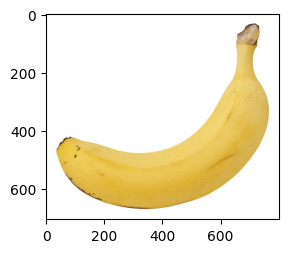

In [14]:
import matplotlib.pyplot as plt
from diffusers.utils import load_image

image = load_image("image02.png")
plt.figure(figsize=(3,3))
plt.imshow(image)
plt.show()

2026-01-26 22:17:40 I [ipykernel_launcher:385] - 이미지 상세 분석 시작 (800x705)
2026-01-26 22:17:40 D [ipykernel_launcher:389] - 사용자 정의 질문: [Product Description from Qwen] placed on [New Background], [Interaction Detail], [Lighting Match], [Technical Quality]


2026-01-26 22:18:01 D [ipykernel_launcher:392] - 사용자 정의 응답: [Product Description from Qwen] placed on [New Background], [Interaction Detail], [Lighting Match], ...
2026-01-26 22:18:01 I [ipykernel_launcher:394] - 이미지 상세 분석 완료
2026-01-26 22:18:01 D [ipykernel_launcher:2] - image_analyze=[Product Description from Qwen] placed on [New Background], [Interaction Detail], [Lighting Match], [Technical Quality]
2026-01-26 22:18:01 I [ipykernel_launcher:571] - FLUX 프롬프트 생성 시작
2026-01-26 22:18:01 D [ipykernel_launcher:572] - product_prompt=[Product Description from Qwen] placed on [New Background], [Interaction Detail], [Lighting Match], [Technical Quality]
2026-01-26 22:18:01 D [ipykernel_launcher:573] - image_edit_prompt=제품이 잘보이게 전면에 그려지고, 배경으로 청과물 가게가 배경으로 흐릿하게 있다. 제품 표면에 검은색 한글로 '원산지:대구' 라는 문구가 적혀있다.
2026-01-26 22:18:01 D [ipykernel_launcher:604] - OpenAI API 호출: model=gpt-5-mini, max_tokens=128000
2026-01-26 22:18:19 D [ipykernel_launcher:615] - API 응답: finish_reason=stop, tokens=1656
2026-

  0%|          | 0/30 [00:00<?, ?it/s]

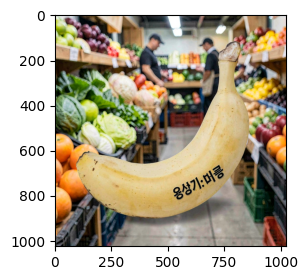

In [15]:
image_analyze = qwen.analyze_image_flux_product(image, auto_unload=False)
logger.debug(f"image_analyze={image_analyze}")

flux_prompt = llm_prompt.generate_flux_prompt(product_prompt=image_analyze, image_edit_prompt="광고용 이미지이다. 제품이 잘보이게 전면에 그려지고, 배경으로 청과물 가게가 배경으로 흐릿하게 있다.")
logger.debug(f"Generated FLUX Prompt: {flux_prompt}")

result_image, seed = flux.generate(prompt=flux_prompt, input_image=image, auto_unload=False)

plt.figure(figsize=(3,3))
plt.imshow(result_image)
plt.show()


2026-01-26 22:19:04 D [ipykernel_launcher:499] - 임시 디렉토리 생성: /tmp/llm_html_26rrl0wr


2026-01-26 22:19:05 D [ipykernel_launcher:505] - PIL Image를 임시 파일로 저장: /tmp/llm_html_26rrl0wr/product_image.png
2026-01-26 22:19:05 I [ipykernel_launcher:212] - HTML 생성 시작: image=/tmp/llm_html_26rrl0wr/product_image.png, text=특가세일 2500원
2026-01-26 22:19:05 I [ipykernel_launcher:215] - QwenAnalyzer로 이미지 분석 중...
2026-01-26 22:19:05 I [ipykernel_launcher:251] - 이미지 상세 분석 시작 (1024x1024)
2026-01-26 22:20:06 D [ipykernel_launcher:260] - 공간 분석 완료: The image features a large, oversized banana in the foreground, positioned centrally in the lower ha...
2026-01-26 22:20:58 D [ipykernel_launcher:269] - 색감/재질 분석 완료: The image features a variety of colors and materials, with the following observations:

- **Dominant...
2026-01-26 22:21:54 D [ipykernel_launcher:278] - 전체 내용 분석 완료: This is a photograph taken inside a bustling, well-lit grocery store or market, focusing on a large,...
2026-01-26 22:22:45 D [ipykernel_launcher:287] - 조명/분위기 분석 완료: The image is illuminated by a bright, even, and artifici

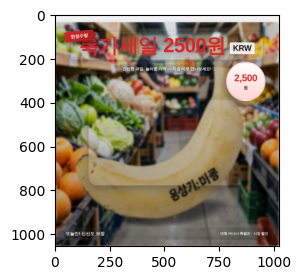

In [16]:
html_image = await llm_prompt.generate_prompt_html_png(
    image=result_image,
    ad_text="특가세일 2500원",
    text_prompt="고급스런 광고 전단지를 만들어야 한다. 빨강색의 굵은 글씨로 시선을 끌게 디자인, 리본 모양의 그래픽 추가",
    composition_prompt="제품은 중앙에 배치, 배경은 흐릿하게 처리, 텍스트는 상단에 크게 배치",
)
plt.figure(figsize=(3,3))
plt.imshow(html_image)
plt.show()

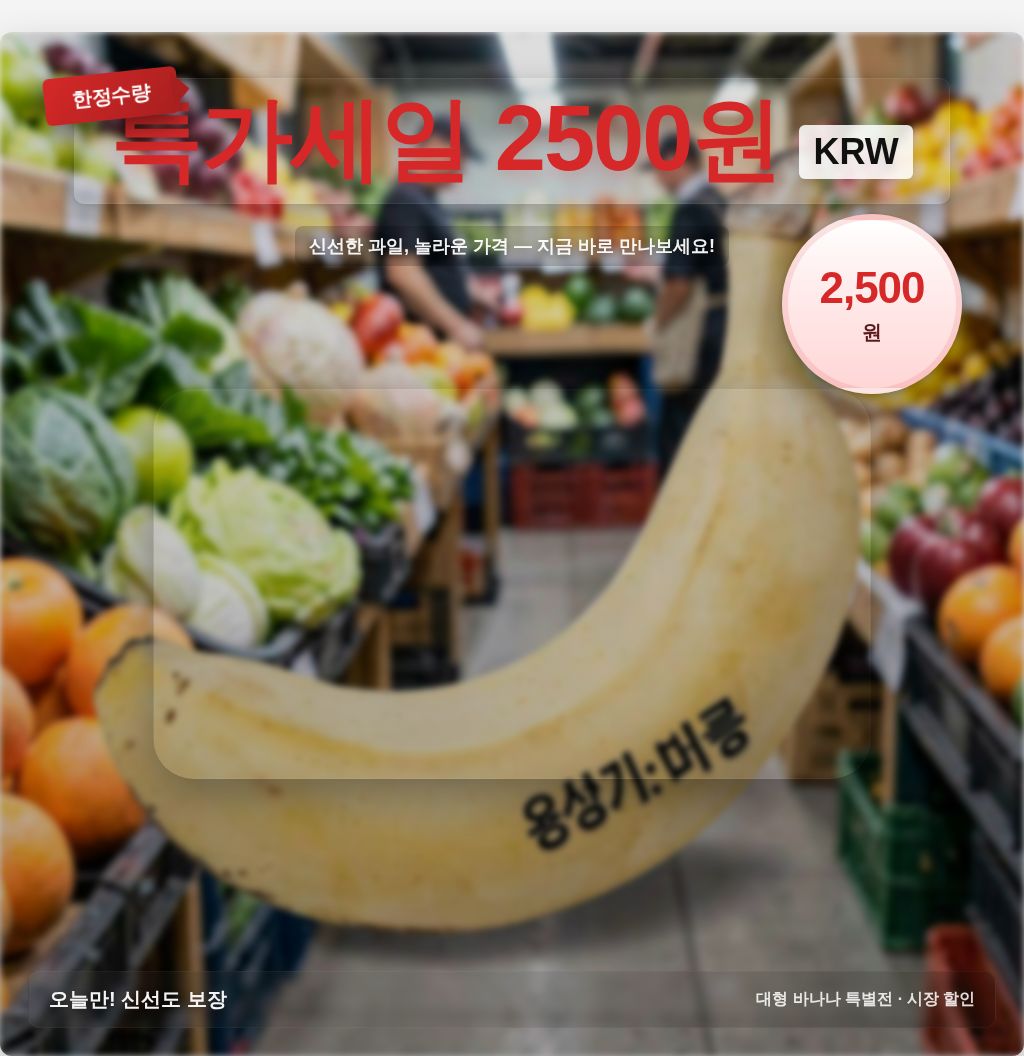

In [17]:
html_image